<a href="https://colab.research.google.com/github/Sukhdeep2006/Learning-TensorFlow/blob/main/10_TF_NPL_RNN_All_Model_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings only vs LSTM vs CNN vs GRU Model Performance

So far, we have been using a small dataset with only 2000 reviews for sentiment analysis using these models and were getting some decent results. But now we will try using a bigger dataset with the reviews in the range of 60K and see how it improves the performance of these models.   

We will also try to predict the sentiments of our own reviews to see how well the performance of our models generalises.

Lets get into it.

We will use the Stanford Sentiment Treebank (SST) dataset that consists of sentences from movie reviews and human annotations of their sentiment. This colab uses version 2 of the SST dataset.   

The splits are:

train 67,349   
validation 872   
and the column headings are:   

sentence   
label   
For more information about the dataset, see https://www.tensorflow.org/datasets/catalog/glue#gluesst2

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### We will download the datset from the URL below.

In [ ]:
# dataset, info = tfds.load('glue/sst2',with_info=True )
# print(dataset.keys())

_url = 'https://dl.fbaipublicfiles.com/glue/data/SST-2.zip'
zip_dir = tf.keras.utils.get_file('reviews.zip',origin= _url,extract = True)
zip_dir_base = os.path.dirname(zip_dir)

os.listdir(os.path.join(zip_dir_base, 'SST-2'))

#print(zip_dir, zip_dir_base, file_path)
# os.listdir(zip_dir_base)
# !find $zip_dir_base -type d -print

['test.tsv', 'train.tsv', 'dev.tsv', 'original']

In [ ]:
train_file_path = os.path.join(zip_dir_base, 'SST-2/train.tsv')
test_file_path = os.path.join(zip_dir_base, 'SST-2/test.tsv')
dev_file_path = os.path.join(zip_dir_base, 'SST-2/dev.tsv')

In [ ]:
train_dataset = pd.read_csv(train_file_path, delimiter='\t')
test_dataset = pd.read_csv(test_file_path, delimiter='\t')
dev_dataset = pd.read_csv(dev_file_path, delimiter='\t')

In [ ]:
print(train_dataset.keys() , test_dataset.keys(), dev_dataset.keys())

train_sentences = train_dataset['sentence'].tolist()[:10000]
train_labels = train_dataset['label'].tolist()[:10000]

#for item in train_dataset:
#  sentence, label = item['sentence'], item['label']
#  train_sentences.append(str(sentence.numpy()))
#  train_sentences.append(label.numpy())

# train_sentences = train_dataset['sentence'].tolist()
# train_labels = train_dataset['label'].tolist()

dev_sentences = dev_dataset['sentence'].tolist()
dev_labels = dev_dataset['label'].tolist()

print(len(train_sentences), len(train_labels),len(dev_sentences),len(dev_labels) , '\n')

#Lets take a look at the first five training sentences and labels.

for i in range(5):
  print( dataset['sentence'][i], dataset['label'][i])

# print(type(train_sentences), type(dev_sentences))


Index(['sentence', 'label'], dtype='object') Index(['index', 'sentence'], dtype='object') Index(['sentence', 'label'], dtype='object')
10000 10000 872 872 

hide new secretions from the parental units  0
contains no wit , only labored gags  0
that loves its characters and communicates something rather beautiful about human nature  1
remains utterly satisfied to remain the same throughout  0
on the worst revenge-of-the-nerds clichés the filmmakers could dredge up  0
<class 'list'> <class 'list'>


In [ ]:
vocab_size = 5000
embedding_dim = 16
trunc_type = 'post'
pad_type = 'post'
oov_token = '<OOV>'
max_length = 50

tokenizer = Tokenizer(num_words=vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index


### Lets define and pad the sequences now

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
dev_sequences = tokenizer.texts_to_sequences(dev_sentences)

train_padded = pad_sequences(train_sequences, max_length, padding = pad_type, truncating=trunc_type)
dev_padded = pad_sequences(dev_sequences, max_length, padding = pad_type, truncating=trunc_type)

training_labels_final = np.array(train_labels)
dev_labels_final = np.array(dev_labels)

### Lets define some fake reviews to test our model's predictions ourselves.


In [ ]:
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]


### Here, we will write some generic methods to look at the perfrmance of each of these models.

In [ ]:
def plot_graph(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel= 'EPOCHS'
  plt.ylabel= string 
  plt.legend([string, 'val_'+ string])
  plt.show()


In [ ]:
def predict_reviews(model, fake_reviews, show_padded_sequence = False):
  
  review_sequences = tokenizer.texts_to_sequences(fake_reviews)
  review_sequences_padded = pad_sequences(review_sequences, maxlen = max_length, padding=pad_type, truncating=trunc_type)    
  predictions =model.predict(review_sequences_padded)
  for i in range(len(predictions)):
    print(fake_reviews[i], predictions[i] )
    if(show_padded_sequence):
      print(review_sequences_padded[i], '\n')

In [ ]:
def fit_and_predict_model(model, num_epochs):
  
  
  model.summary()
  history = model.fit(train_padded, training_labels_final, epochs= num_epochs, validation_data=(dev_padded, dev_labels_final) )
  plot_graph(history, 'loss')
  plot_graph(history, 'accuracy')
  predict_reviews(model, fake_reviews, show_padded_sequence = False)

### We got all the ingradients ready before we mix them up and cook our model.

### Remember, we are going to try the following different models this time:



*   Embeddings Only
*   CNN
*   GRU
*   LSTM
*   Stacked LSTM

Lets start with creating an Embeddings only model and see how it performs.



In [ ]:
model_embed = tf.keras.models.Sequential([
                                          tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                          tf.keras.layers.GlobalAveragePooling1D(),
                                          tf.keras.layers.Dense(1, activation='sigmoid')
])

model_embed.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 16)            80000     
_________________________________________________________________
global_average_pooling1d_5 ( (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 80,017
Trainable params: 80,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
313/313 [==============================] - 1s 3ms/step - loss: 0.6900 - accuracy: 0.5528 - val_loss: 0.6926 - val_accuracy: 0.5092
Epoch 2/25
313/313 [==============================] - 1s 2ms/step - loss: 0.6874 - accuracy: 0.5529 - val_loss: 0.6926 - val_accuracy: 0.5092
Epoch 3/25
313/313 [==============================] - 1s 2ms/step - loss: 0.6859 - accuracy: 0.5

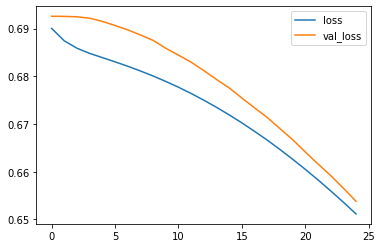

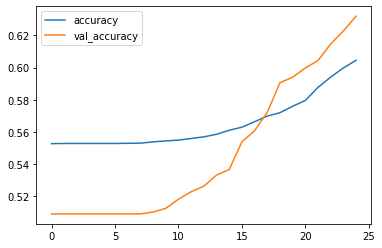

I love this phone [0.56140137]
Everything was cold [0.54590786]
Everything was hot exactly as I wanted [0.5322434]
Everything was green [0.55382675]
the host seated us immediately [0.57033366]
they gave us free chocolate cake [0.5323923]
we couldn't hear each other talk because of the shouting in the kitchen [0.531145]


In [ ]:
fit_and_predict_model(model_embed, 25)


In [ ]:
model_cnn = tf.keras.models.Sequential([
                          tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                          tf.keras.layers.Conv1D(16, 5, activation = 'relu'),
                          tf.keras.layers.GlobalMaxPooling1D(),
                          tf.keras.layers.Dense(1, activation = 'sigmoid')              
])

learn_rate = 0.0001
model_cnn.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics = ['accuracy'])


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 16)            80000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 81,313
Trainable params: 81,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
313/313 [==============================] - 2s 4ms/step - loss: 0.6913 - accuracy: 0.5278 - val_loss: 0.6923 - val_accuracy: 0.5092
Epoch 2/25
313/313 [==============================] - 1s 4ms/step - loss: 0.6856 - accuracy: 0.5529 - val_

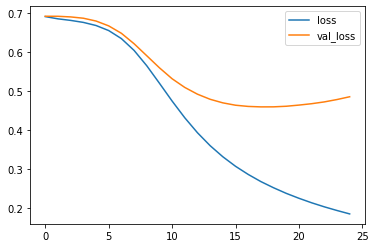

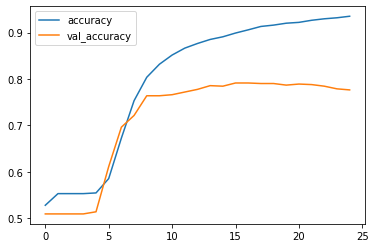

I love this phone [0.9607926]
Everything was cold [0.03361651]
Everything was hot exactly as I wanted [0.09880173]
Everything was green [0.18949673]
the host seated us immediately [0.92167175]
they gave us free chocolate cake [0.74598527]
we couldn't hear each other talk because of the shouting in the kitchen [0.82087255]


In [ ]:
fit_and_predict_model(model_cnn, 25)

In [ ]:
model_gru = tf.keras.models.Sequential([
                          tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                          tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
                          tf.keras.layers.Dense(1, activation = 'sigmoid')              
])

learn_rate = 0.00003
model_gru.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics = ['accuracy'])


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 16)            80000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 89,665
Trainable params: 89,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
313/313 [==============================] - 15s 38ms/step - loss: 0.6904 - accuracy: 0.5519 - val_loss: 0.6932 - val_accuracy: 0.5092
Epoch 2/25
313/313 [==============================] - 11s 36ms/step - loss: 0.6878 - accuracy: 0.5529 - val_loss: 0.6939 - val_accuracy: 0.5092
Epoch 3/25
313/313 [==============================] - 11s 36ms/step - loss: 0.6864 - accura

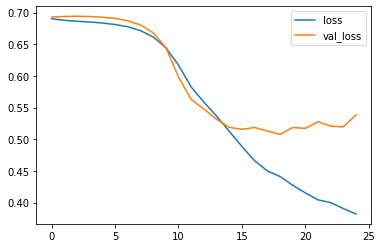

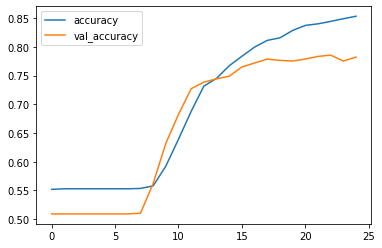

I love this phone [0.680375]
Everything was cold [0.30149537]
Everything was hot exactly as I wanted [0.16721022]
Everything was green [0.41892827]
the host seated us immediately [0.7401765]
they gave us free chocolate cake [0.5826027]
we couldn't hear each other talk because of the shouting in the kitchen [0.39594448]


In [ ]:
fit_and_predict_model(model_gru, 25)

In [ ]:
model_bidi_lstm = tf.keras.models.Sequential([
                          tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
                          tf.keras.layers.Dense(1, activation = 'sigmoid')              
])

learn_rate = 0.00003
model_bidi_lstm.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics = ['accuracy'])


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 50, 16)            80000     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 84,257
Trainable params: 84,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
313/313 [==============================] - 13s 32ms/step - loss: 0.6922 - accuracy: 0.5360 - val_loss: 0.6930 - val_accuracy: 0.5092
Epoch 2/25
313/313 [==============================] - 9s 29ms/step - loss: 0.6895 - accuracy: 0.5529 - val_loss: 0.6932 - val_accuracy: 0.5092
Epoch 3/25
313/313 [==============================] - 9s 30ms/step - loss: 0.6876 - accuracy

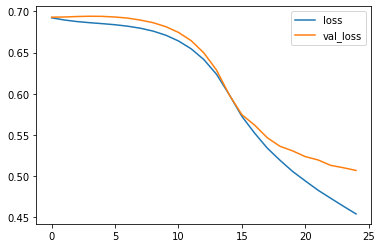

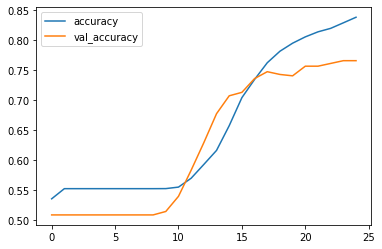

I love this phone [0.58895123]
Everything was cold [0.3430191]
Everything was hot exactly as I wanted [0.29488957]
Everything was green [0.39923894]
the host seated us immediately [0.67099065]
they gave us free chocolate cake [0.41831902]
we couldn't hear each other talk because of the shouting in the kitchen [0.43437618]


In [ ]:
fit_and_predict_model(model_bidi_lstm, 25)

In [ ]:
model_multi_bidi_lstm = tf.keras.models.Sequential([
                          tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = True)),
                          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences = False)),
                          tf.keras.layers.Dense(1, activation = 'sigmoid')              
])

learn_rate = 0.0003
model_multi_bidi_lstm.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), metrics = ['accuracy'])


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 16)            80000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 90,529
Trainable params: 90,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
313/313 [==============================] - 26s 63ms/step - loss: 0.6844 - accuracy: 0.5543 - val_loss: 0.6696 - val_accuracy: 0.6158
Epoch 2/30
313/313 [==============================] - 18s 58ms/step - loss: 0.4709 - accuracy: 0.7772 -

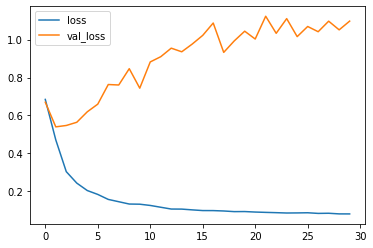

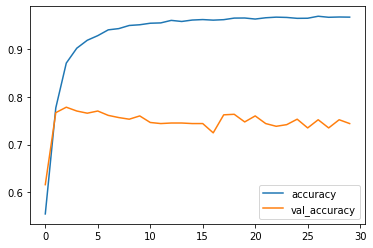

I love this phone [0.99542814]
Everything was cold [0.00801039]
Everything was hot exactly as I wanted [0.00717714]
Everything was green [0.00749823]
the host seated us immediately [0.99663943]
they gave us free chocolate cake [0.99456394]
we couldn't hear each other talk because of the shouting in the kitchen [0.98710275]


In [ ]:
fit_and_predict_model(model_multi_bidi_lstm, 30)

In [ ]:
more_reviews = ['''woo''s fights have a distinct flair .''', '''
he has not learned that storytelling is what the movies are about .''','''
if you liked the 1982 film then , you ''ll still like it now .''','''
despite some gulps the film is a fuzzy huggy .''','''
the film is painfully authentic, and the performances of the young players are utterly convincing .''','''
there are just enough twists in the tale to make it far more satisfying than almost any horror film in recent memory .''','''
this is n''t just the cliffsnotes version of nicholas nickleby , it ''s the cliffsnotes with pages missing .''','''
an entire film about researchers quietly reading dusty old letters . ''','''
nothing more than a mediocre trifle .''','''
a model of what films like this should be like .''','''
showtime is closer to slowtime .''',"""that was the worst movie I've ever seen""", """too much violence even for a Bond film""", """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it.""", """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring""", """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!""", "I wish I could watch this movie every day for the rest of my life",]

In [ ]:
for review in more_reviews:
  print('\n', review)


 woo''s fights have a distinct flair .

 
he has not learned that storytelling is what the movies are about .

 
if you liked the 1982 film then , you ''ll still like it now .

 
despite some gulps the film is a fuzzy huggy .

 
the film is painfully authentic, and the performances of the young players are utterly convincing .

 
there are just enough twists in the tale to make it far more satisfying than almost any horror film in recent memory .

 
this is n''t just the cliffsnotes version of nicholas nickleby , it ''s the cliffsnotes with pages missing .

 
an entire film about researchers quietly reading dusty old letters . 

 
nothing more than a mediocre trifle .

 
a model of what films like this should be like .

 
showtime is closer to slowtime .

 that was the worst movie I've ever seen

 too much violence even for a Bond film

 I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day,

In [ ]:
print("============================\n","Embeddings only:\n", "============================")
predict_reviews(model_embed, more_reviews, show_padded_sequence = False)

print("============================\n","with CNN:\n", "============================")
predict_reviews(model_cnn, more_reviews, show_padded_sequence = False)

print("============================\n","with Bidirection GRU:\n", "============================")
predict_reviews(model_gru, more_reviews, show_padded_sequence = False)

print("============================\n","with BiDi LSTM:\n", "============================")
predict_reviews(model_bidi_lstm, more_reviews, show_padded_sequence = False)

print("============================\n","with Multi LSTM:\n", "============================")
predict_reviews(model_multi_bidi_lstm, more_reviews, show_padded_sequence = False)


 Embeddings only:
woo''s fights have a distinct flair . [0.5572045]

he has not learned that storytelling is what the movies are about . [0.54157495]

if you liked the 1982 film then , you ''ll still like it now . [0.54049397]

despite some gulps the film is a fuzzy huggy . [0.54526025]

the film is painfully authentic, and the performances of the young players are utterly convincing . [0.6090355]

there are just enough twists in the tale to make it far more satisfying than almost any horror film in recent memory . [0.5022662]

this is n''t just the cliffsnotes version of nicholas nickleby , it ''s the cliffsnotes with pages missing . [0.4835162]

an entire film about researchers quietly reading dusty old letters .  [0.55166715]

nothing more than a mediocre trifle . [0.52896553]

a model of what films like this should be like . [0.52565205]

showtime is closer to slowtime . [0.5224478]
that was the worst movie I've ever seen [0.5166635]
too much violence even for a Bond film [0.529138